# OPTIMIZACION DEL PROCESO DE PRODUCCION DE ETANOL A PARTIR DE MAIZ 

* Integrantes: 
    Ronald Borja 
    Carlos Garcial 
    Samuel Gonzales 
    Gabriela Quintero

In [44]:
# Librerías 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from math import exp, sqrt, log, pi

# C6H12O6 --> 2CH3CH2OH + 2CO2
#   A     --> 2B        + 2B

In [45]:
# Valores iniciales 
xA = 0.2        # Conversión en el fermentador
R = 1.5         # Relación de reflujo 
ze = 0.1        # Composición de etanol a la salida 


# Economía 
tasai = 0.085   # Tasa de interés de la planta 
n = 10          # Tiempo de evaluación 

## COLUMNA DE DESTILACION

In [46]:
# Flujo volumetrico producción
Q = 1e6*(3.78541)*(1/350)*(1/24)              # Produccion [L/h]

# Propiedades fisicoquimicas del destilado
dEtOH = 789                                    # Densidad etanol [kg/m3] 
dH2O = 997                                     # Densidad agua [kg/m3]
MEtOH = 46.068                                 # Peso molecular etanol [kg/kmol]
MH2O = 18.015                                  # Peso molecular agua [kg/kmol]
alfa = 3.5                                     # Volatilidad relativa mezcla 
heatVap = 40.79*1000                           # Entalpía de vaporización del agua [kJ/kmol] 

# Fracciones de recuperación del componente más volatil 
ye = 0.95                                      # Fracción etanol en el tope 
xe = 0.01                                      # Fraccion etanol en el fondo 

mD = Q*(1/1000)*(dEtOH*ye + (1-ye)*dH2O)       # Flujo másico destilado [kg/h]
D = mD/(MEtOH*ye + (1-ye)*MH2O)                # Flujo molar destilad [kmol/h]

# Calculos de diseño -> FUG 
V = (1 + R)*D                                  # Flujo molar vapor [kmol/h]
F = ((ye - xe)/(ze - xe))*D                    # Flujo molar alimentacion [kmol/h]
Rmin = 2/(alfa - 1)                            # Relacion de reflujo 
X = (R - Rmin)/(R + 1)
Y = 1 - exp(((1 + 54.4*X)/(11 + 117.2*X))*(X - 1)/sqrt(X))
Nmin = log((ye/xe)*(1-ye)/(1-xe))/log(alfa)    # Numero de etapas mínimas 
N = (Y + Nmin)/(1 - Y)
L = N                                          # Longitud de la columa [m]
d = 0.15*sqrt(V)                               # Diametro de la columna [m]
VC = (pi/4)*L*d**2                             # Volumen de la columa [m^3]


# Costos: 
PC_dist = 1.3*10000*VC**0.85                   # Precio de la columna 
PC_dist = PC_dist*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1) 
UC_cw = 3.54e-7*V*heatVap*(24*350)             # Precio del agua de enfriamiento [dol/yr]
UC_s = UC_cw*20                                # Precio del servicio de calientamiento [dol/yr]

## FERMENTADOR 

In [47]:
# Temperatura de reacción 
T = 35 + 273.15 # [K]
MGluc = 180.16  # [kmol/kg]
dGluc = 1560    # [kg/m3]

# Calculos de diseño
FEtOH = F*ze    # [kmol/h]
FH2O = F - FEtOH # [kmol/h]
avance = FEtOH/2 # [kmol/h]

# Calculo de flujos molares 
FGluc0 = avance/xA # [kmol/h]
FH2O0 = FH2O       # [kmol/h]

# Calculo de flujos másicas 
mFeedH2O = FH2O0*MH2O   # [kg/h]
mFeedGluc = FGluc0*MGluc # [kg/h]

# Flujo volumetrico 
V_feedH2O = mFeedH2O/dH2O # [m3/h]
V_feedGluc = mFeedGluc/dGluc # [m3/h]

# Flujos de alimento al fermentador
Fin = FGluc0 + FH2O         # [kmol/h]
Min = mFeedH2O + mFeedGluc  # [kg/h]
V_feed = (V_feedH2O + V_feedGluc)*1000 # [L/h]

k = 1.5*exp(-3500/T) # [s-1]
tf = (1/k)*(1/(0.5 - xA))  # [s]
tf_total = (tf/3600) + 5   # [h]
V_fermentador = V_feed*tf_total  # [L]

# Costo del fermentador 
PC_reactor = 7500*(V_fermentador**0.5)     # plata
PC_reactor = PC_reactor*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1)   #plata/años

# Costos utilidades 
UC_CalF = (5e-6)*V_fermentador*(574.79/1000)*(24*350)   #plata/año
UC_limp = 1000*(1 + 0.5*(V_fermentador/1000))

## INTERCAMBIADOR DE CALOR 

In [48]:
# Parametros de diseño 
F_corr = 0.8
U = 500 # W/m2 k
TmixIn = 150 #[°C] 
TmixOut = 35 #[°C]
TcIn = 25    #[°C]
TcOut = 65   #[°C]
Cp = 4.184*1000 #[J/kg °C]

# Calculo de diseño
M_mix = Min*(1/3600) #Kg/s
dTml = ((TmixOut-TcIn)-(TmixIn-TcOut))/log((TmixOut-TcIn)/(TmixIn-TcOut))
Q_I = M_mix*Cp*(TmixIn - TmixOut)
A = Q/(U*F*dTml)

# Costo intercambiador 
PC_hx = 12000*(A**0.67)
PC_hx = PC_hx*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1) 

#Servicios 
UC_CWHx = (5e-6)*(Q_I*(3600/1000)*(24*350))

## MOLIENDA 

In [49]:
# Precio del molino
mAlmidon = (mFeedGluc/0.9) #[kg/h]
mMaiz = mAlmidon/0.65 #[kg/h]
dMaiz = 700 
Cslurry = 0.15 

mAgua = (mMaiz*(1 - Cslurry))/Cslurry #kg/h
Qagua = mAgua/dH2O  #m3/h

Qmaiz = mMaiz/dMaiz #m3/h 
Vfeed = (Qagua + Qmaiz)*(1000) # L/h

# Costo suministro de agua
tmill = 12/60    # h 
Vmill = 1.2*Vfeed*tmill #L

# Precio del equipo 
PCmill = 5000*Vmill**0.42
PCmill = PCmill*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1) 

# Precio suministros 
UCwater = 100/1000*(Qagua*24*350)

In [50]:
mEnzimas = mAlmidon #Unidades 
PEnzimas = (75/10000)*mEnzimas 

# Costo de hidrolización 
UCheatingH = 5e-6*Vmill*(0.932/10)

# CALCULO DEL EAOC 

In [51]:
PrecioMaiz = (4/25.40)*mMaiz*24*365


EAOC= Costo molino+ Costo intercambiador de calor+ Costo fermentador+ Costo columna destilación+ Costos maíz+ Costo del agua+ Costo enzimas+ Costo energía enfriamiento+ Costos calefacción para mantener la T + Costo Energía Destilación+ Costo agua enfriamiento + Costo limpieza  

In [52]:
EAOC = PC_dist + UC_cw + UC_s + PC_reactor + UC_CalF + UC_limp + PC_hx + UC_CWHx + PCmill + UCwater + PEnzimas + UCheatingH + PrecioMaiz
print(EAOC)

9826326.005499324


# OPTIMIZACION FIJANDO DOS VARIABLES 

In [53]:
# Valores fijos 
xA = 0.3 
ze = 0.05 
resultados = []
j = 1 

for i in np.arange(0.81, 0.9, 0.001): 
    # Economía 
    tasai = 0.085   # Tasa de interés de la planta 
    n = 10          # Tiempo de evaluación 

    # Flujo volumetrico producción
    Q = 1e6*(3.78541)*(1/350)*(1/24)              # Produccion [L/h]

    # Propiedades fisicoquimicas del destilado
    dEtOH = 789                                    # Densidad etanol [kg/m3] 
    dH2O = 997                                     # Densidad agua [kg/m3]
    MEtOH = 46.068                                 # Peso molecular etanol [kg/kmol]
    MH2O = 18.015                                  # Peso molecular agua [kg/kmol]
    alfa = 3.5                                     # Volatilidad relativa mezcla 
    heatVap = 40.79*1000                           # Entalpía de vaporización del agua [kJ/kmol] 

    # Fracciones de recuperación del componente más volatil 
    ye = 0.95                                      # Fracción etanol en el tope 
    xe = 0.01                                      # Fraccion etanol en el fondo 

    mD = Q*(1/1000)*(dEtOH*ye + (1-ye)*dH2O)       # Flujo másico destilado [kg/h]
    D = mD/(MEtOH*ye + (1-ye)*MH2O)                # Flujo molar destilad [kmol/h]

    # Calculos de diseño -> FUG 
    V = (1 + i)*D                                  # Flujo molar vapor [kmol/h]
    F = ((ye - xe)/(ze - xe))*D                    # Flujo molar alimentacion [kmol/h]
    Rmin = 2/(alfa - 1)                            # Relacion de reflujo 
    X = (i - Rmin)/(i + 1)
    Y = 1 - exp(((1 + 54.4*X)/(11 + 117.2*X))*(X - 1)/sqrt(X))
    Nmin = log((ye/xe)*(1-ye)/(1-xe))/log(alfa)    # Numero de etapas mínimas 
    N = (Y + Nmin)/(1 - Y)
    L = N                                          # Longitud de la columa [m]
    d = 0.15*sqrt(V)                               # Diametro de la columna [m]
    VC = (pi/4)*L*d**2                             # Volumen de la columa [m^3]


    # Costos: 
    PC_dist = 1.3*10000*VC**0.85                   # Precio de la columna 
    PC_dist = PC_dist*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1) 
    UC_cw = 3.54e-7*V*heatVap*(24*350)             # Precio del agua de enfriamiento [dol/yr]
    UC_s = UC_cw*20                                # Precio del servicio de calientamiento [dol/yr]
    
    
    # Temperatura de reacción 
    T = 35 + 273.15 # [K]
    MGluc = 180.16  # [kmol/kg]
    dGluc = 1560    # [kg/m3]

    # Calculos de diseño
    FEtOH = F*ze    # [kmol/h]
    FH2O = F - FEtOH # [kmol/h]
    avance = FEtOH/2 # [kmol/h]

    # Calculo de flujos molares 
    FGluc0 = avance/xA # [kmol/h]
    FH2O0 = FH2O       # [kmol/h]

    # Calculo de flujos másicas 
    mFeedH2O = FH2O0*MH2O   # [kg/h]
    mFeedGluc = FGluc0*MGluc # [kg/h]

    # Flujo volumetrico 
    V_feedH2O = mFeedH2O/dH2O # [m3/h]
    V_feedGluc = mFeedGluc/dGluc # [m3/h]

    # Flujos de alimento al fermentador
    Fin = FGluc0 + FH2O         # [kmol/h]
    Min = mFeedH2O + mFeedGluc  # [kg/h]
    V_feed = (V_feedH2O + V_feedGluc)*1000 # [L/h]

    k = 1.5*exp(-3500/T) # [s-1]
    tf = (1/k)*(1/(0.5 - xA))  # [s]
    tf_total = (tf/3600) + 5   # [h]
    V_fermentador = V_feed*tf_total  # [L]

    # Costo del fermentador 
    PC_reactor = 7500*(V_fermentador**0.5)     # plata
    PC_reactor = PC_reactor*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1)   #plata/años

    # Costos utilidades 
    UC_CalF = (5e-6)*V_fermentador*(574.79/1000)*(24*350)   #plata/año
    UC_limp = 1000*(1 + 0.5*(V_fermentador/1000))
    
    # Parametros de diseño 
    F_corr = 0.8
    U = 500 # W/m2 k
    TmixIn = 150 #[°C] 
    TmixOut = 35 #[°C]
    TcIn = 25    #[°C]
    TcOut = 65   #[°C]
    Cp = 4.184*1000 #[J/kg °C]

    # Calculo de diseño
    M_mix = Min*(1/3600) #Kg/s
    dTml = ((TmixOut-TcIn)-(TmixIn-TcOut))/log((TmixOut-TcIn)/(TmixIn-TcOut))
    Q_I = M_mix*Cp*(TmixIn - TmixOut)
    A = Q/(U*F*dTml)

    # Costo intercambiador 
    PC_hx = 12000*(A**0.67)
    PC_hx = PC_hx*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1) 

    #Servicios 
    UC_CWHx = (5e-6)*(Q_I*(3600/1000)*(24*350))
    
    # Precio del molino
    mAlmidon = (mFeedGluc/0.9) #[kg/h]
    mMaiz = mAlmidon/0.65 #[kg/h]
    dMaiz = 700 
    Cslurry = 0.15 

    mAgua = (mMaiz*(1 - Cslurry))/Cslurry #kg/h
    Qagua = mAgua/dH2O  #m3/h

    Qmaiz = mMaiz/dMaiz #m3/h 
    Vfeed = (Qagua + Qmaiz)*(1000) # L/h

    # Costo suministro de agua
    tmill = 12/60    # h 
    Vmill = 1.2*Vfeed*tmill #L

    # Precio del equipo 
    PCmill = 5000*Vmill**0.42
    PCmill = PCmill*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1)

    # Precio suministros 
    UCwater = 100/1000*(Qagua*24*350)

    mEnzimas = mAlmidon #Unidades 
    PEnzimas = (75/10000)*mEnzimas 

    # Costo de hidrolización 
    UCheatingH = 5e-6*Vmill*(0.932/10)
    
    PrecioMaiz = (4/25.40)*mMaiz*24*365
    EAOC = PC_dist + UC_cw + UC_s + PC_reactor + UC_CalF + UC_limp + PC_hx + UC_CWHx + PCmill + UCwater + PEnzimas + UCheatingH + PrecioMaiz
    resultados.append(EAOC)
    
    print(f"Agregando el resultado {j} con R = {round(i,3)}...")
    j += 1

Agregando el resultado 1 con R = 0.81...
Agregando el resultado 2 con R = 0.811...
Agregando el resultado 3 con R = 0.812...
Agregando el resultado 4 con R = 0.813...
Agregando el resultado 5 con R = 0.814...
Agregando el resultado 6 con R = 0.815...
Agregando el resultado 7 con R = 0.816...
Agregando el resultado 8 con R = 0.817...
Agregando el resultado 9 con R = 0.818...
Agregando el resultado 10 con R = 0.819...
Agregando el resultado 11 con R = 0.82...
Agregando el resultado 12 con R = 0.821...
Agregando el resultado 13 con R = 0.822...
Agregando el resultado 14 con R = 0.823...
Agregando el resultado 15 con R = 0.824...
Agregando el resultado 16 con R = 0.825...
Agregando el resultado 17 con R = 0.826...
Agregando el resultado 18 con R = 0.827...
Agregando el resultado 19 con R = 0.828...
Agregando el resultado 20 con R = 0.829...
Agregando el resultado 21 con R = 0.83...
Agregando el resultado 22 con R = 0.831...
Agregando el resultado 23 con R = 0.832...
Agregando el resultado 

In [54]:
R = np.arange(0.81, 0.9, 0.001)

df = pd.DataFrame({"R. Reflujo": R, 
                   "EAOC": resultados})

df.head()

,R. Reflujo,EAOC
0,0.810,7.904954e+06
1,0.811,7.904806e+06
2,0.812,7.904687e+06
3,0.813,7.904591e+06
4,0.814,7.904512e+06


El valor mínimo es 7904170.1197 $/yr para un R = 0.829 


C:\Users\Carlos Garcia E\AppData\Local\Temp\ipykernel_10660\874659446.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


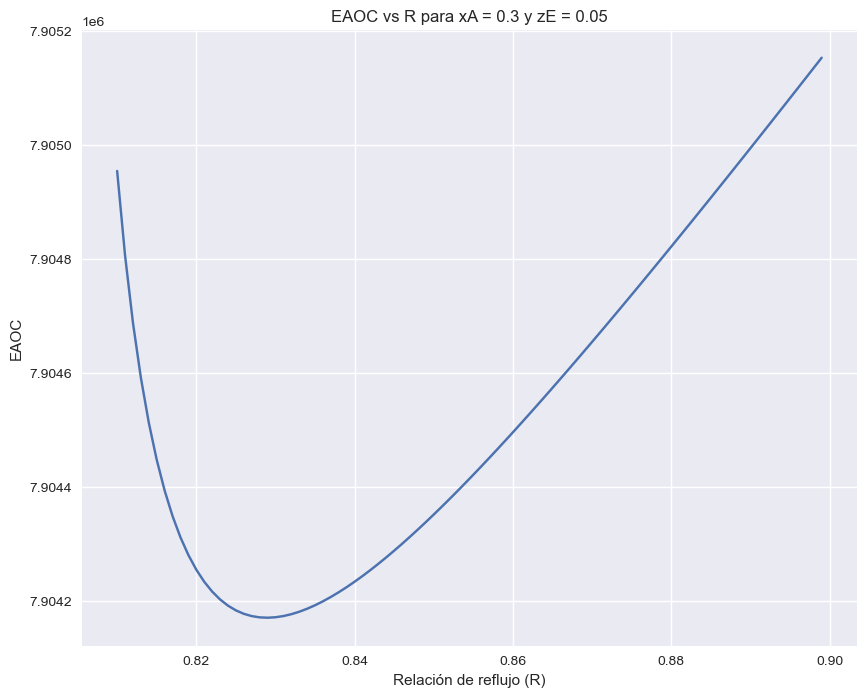

In [55]:
ind = df['EAOC'].idxmin()
print(f"El valor mínimo es {round(df.loc[ind, 'EAOC'],4)} $/yr para un R = {round(df.loc[ind, 'R. Reflujo'],4)} ")

plt.style.use('seaborn')
fig, axis = plt.subplots(figsize =(10,8))
axis.plot(df["R. Reflujo"], df["EAOC"])
plt.title("EAOC vs R para xA = 0.3 y zE = 0.05")
plt.xlabel("Relación de reflujo (R)")
plt.ylabel("EAOC")
plt.show()

# OPTIMIZACION FIJANDO UNA VARIABLE

In [56]:
# Valores fijos 
xA = 0.3
resultados_finales = []
r = 1

for i in np.arange(0.03, 0.1, 0.01): #Composicion etanol (Ze)
    resultados = []
    resultados_finales.append(resultados)
    print(f"Realizando la iteracion {r} para ze = {round(i,3)}")
    print("   Calculando valores de EAOC...")
    r += 1
    
    
    for j in np.arange(0.81, 0.9, 0.001): #Reflujo 
        # Economía 
        tasai = 0.085   # Tasa de interés de la planta 
        n = 10          # Tiempo de evaluación 

        # Flujo volumetrico producción
        Q = 1e6*(3.78541)*(1/350)*(1/24)              # Produccion [L/h]

        # Propiedades fisicoquimicas del destilado
        dEtOH = 789                                    # Densidad etanol [kg/m3] 
        dH2O = 997                                     # Densidad agua [kg/m3]
        MEtOH = 46.068                                 # Peso molecular etanol [kg/kmol]
        MH2O = 18.015                                  # Peso molecular agua [kg/kmol]
        alfa = 3.5                                     # Volatilidad relativa mezcla 
        heatVap = 40.79*1000                           # Entalpía de vaporización del agua [kJ/kmol] 

        # Fracciones de recuperación del componente más volatil 
        ye = 0.95                                      # Fracción etanol en el tope 
        xe = 0.01                                      # Fraccion etanol en el fondo 

        mD = Q*(1/1000)*(dEtOH*ye + (1-ye)*dH2O)       # Flujo másico destilado [kg/h]
        D = mD/(MEtOH*ye + (1-ye)*MH2O)                # Flujo molar destilad [kmol/h]

        # Calculos de diseño -> FUG 
        V = (1 + j)*D                                  # Flujo molar vapor [kmol/h]
        F = ((ye - xe)/(i - xe))*D                    # Flujo molar alimentacion [kmol/h]
        Rmin = 2/(alfa - 1)                            # Relacion de reflujo 
        X = (j - Rmin)/(j + 1)
        Y = 1 - exp(((1 + 54.4*X)/(11 + 117.2*X))*(X - 1)/sqrt(X))
        Nmin = log((ye/xe)*(1-ye)/(1-xe))/log(alfa)    # Numero de etapas mínimas 
        N = (Y + Nmin)/(1 - Y)
        L = N                                          # Longitud de la columa [m]
        d = 0.15*sqrt(V)                               # Diametro de la columna [m]
        VC = (pi/4)*L*d**2                             # Volumen de la columa [m^3]


        # Costos: 
        PC_dist = 1.3*10000*VC**0.85                   # Precio de la columna 
        PC_dist = PC_dist*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1) 
        UC_cw = 3.54e-7*V*heatVap*(24*350)             # Precio del agua de enfriamiento [dol/yr]
        UC_s = UC_cw*20                                # Precio del servicio de calientamiento [dol/yr]


        # Temperatura de reacción 
        T = 35 + 273.15 # [K]
        MGluc = 180.16  # [kmol/kg]
        dGluc = 1560    # [kg/m3]

        # Calculos de diseño
        FEtOH = F*i    # [kmol/h]
        FH2O = F - FEtOH # [kmol/h]
        avance = FEtOH/2 # [kmol/h]

        # Calculo de flujos molares 
        FGluc0 = avance/xA # [kmol/h]
        FH2O0 = FH2O       # [kmol/h]

        # Calculo de flujos másicas 
        mFeedH2O = FH2O0*MH2O   # [kg/h]
        mFeedGluc = FGluc0*MGluc # [kg/h]

        # Flujo volumetrico 
        V_feedH2O = mFeedH2O/dH2O # [m3/h]
        V_feedGluc = mFeedGluc/dGluc # [m3/h]

        # Flujos de alimento al fermentador
        Fin = FGluc0 + FH2O         # [kmol/h]
        Min = mFeedH2O + mFeedGluc  # [kg/h]
        V_feed = (V_feedH2O + V_feedGluc)*1000 # [L/h]

        k = 1.5*exp(-3500/T) # [s-1]
        tf = (1/k)*(1/(0.5 - xA))  # [s]
        tf_total = (tf/3600) + 5   # [h]
        V_fermentador = V_feed*tf_total  # [L]

        # Costo del fermentador 
        PC_reactor = 7500*(V_fermentador**0.5)     # plata
        PC_reactor = PC_reactor*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1)   #plata/años

        # Costos utilidades 
        UC_CalF = (5e-6)*V_fermentador*(574.79/1000)*(24*350)   #plata/año
        UC_limp = 1000*(1 + 0.5*(V_fermentador/1000))

        # Parametros de diseño 
        F_corr = 0.8
        U = 500 # W/m2 k
        TmixIn = 150 #[°C] 
        TmixOut = 35 #[°C]
        TcIn = 25    #[°C]
        TcOut = 65   #[°C]
        Cp = 4.184*1000 #[J/kg °C]

        # Calculo de diseño
        M_mix = Min*(1/3600) #Kg/s
        dTml = ((TmixOut-TcIn)-(TmixIn-TcOut))/log((TmixOut-TcIn)/(TmixIn-TcOut))
        Q_I = M_mix*Cp*(TmixIn - TmixOut)
        A = Q/(U*F*dTml)

        # Costo intercambiador 
        PC_hx = 12000*(A**0.67)
        PC_hx = PC_hx*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1) 

        #Servicios 
        UC_CWHx = (5e-6)*(Q_I*(3600/1000)*(24*350))

        # Precio del molino
        mAlmidon = (mFeedGluc/0.9) #[kg/h]
        mMaiz = mAlmidon/0.65 #[kg/h]
        dMaiz = 700 
        Cslurry = 0.15 

        mAgua = (mMaiz*(1 - Cslurry))/Cslurry #kg/h
        Qagua = mAgua/dH2O  #m3/h

        Qmaiz = mMaiz/dMaiz #m3/h 
        Vfeed = (Qagua + Qmaiz)*(1000) # L/h

        # Costo suministro de agua
        tmill = 12/60    # h 
        Vmill = 1.2*Vfeed*tmill #L

        # Precio del equipo 
        PCmill = 5000*Vmill**0.42
        PCmill = PCmill*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1)

        # Precio suministros 
        UCwater = 100/1000*(Qagua*24*350)

        mEnzimas = mAlmidon #Unidades 
        PEnzimas = (75/10000)*mEnzimas 

        # Costo de hidrolización 
        UCheatingH = 5e-6*Vmill*(0.932/10)

        PrecioMaiz = (4/25.40)*mMaiz*24*365
        EAOC = PC_dist + UC_cw + UC_s + PC_reactor + UC_CalF + UC_limp + PC_hx + UC_CWHx + PCmill + UCwater + PEnzimas + UCheatingH + PrecioMaiz
        resultados.append(EAOC)
        

Realizando la iteracion 1 para ze = 0.03
   Calculando valores de EAOC...
Realizando la iteracion 2 para ze = 0.04
   Calculando valores de EAOC...
Realizando la iteracion 3 para ze = 0.05
   Calculando valores de EAOC...
Realizando la iteracion 4 para ze = 0.06
   Calculando valores de EAOC...
Realizando la iteracion 5 para ze = 0.07
   Calculando valores de EAOC...
Realizando la iteracion 6 para ze = 0.08
   Calculando valores de EAOC...
Realizando la iteracion 7 para ze = 0.09
   Calculando valores de EAOC...
Realizando la iteracion 8 para ze = 0.1
   Calculando valores de EAOC...


In [57]:
composiciones = np.arange(0.03, 0.1, 0.01)
reflujo = np.arange(0.81, 0.9, 0.001)
df = pd.DataFrame()

# Recorre las filas de la matriz y agrega cada fila como una columna en el DataFrame
for o, lista in enumerate(resultados_finales):
    
    column_name = f'ze = {round(composiciones[o],4)}'  # Nombre de la columna
    df[column_name] = lista

    
# El DataFrame ahora contendrá las listas como columnas
df.index = [f'R = {round(r,3)}' for r in reflujo]
df.head(10)

,ze = 0.03,ze = 0.04,ze = 0.05,ze = 0.06,ze = 0.07,ze = 0.08,ze = 0.09,ze = 0.1
R = 0.81,9.738660e+06,8.523827e+06,7.904954e+06,7.528356e+06,7.274458e+06,7.091422e+06,6.953075e+06,6.844754e+06
R = 0.811,9.738512e+06,8.523679e+06,7.904806e+06,7.528209e+06,7.274310e+06,7.091274e+06,6.952927e+06,6.844606e+06
R = 0.812,9.738393e+06,8.523560e+06,7.904687e+06,7.528090e+06,7.274192e+06,7.091155e+06,6.952808e+06,6.844488e+06
R = 0.813,9.738297e+06,8.523464e+06,7.904591e+06,7.527994e+06,7.274096e+06,7.091059e+06,6.952712e+06,6.844392e+06
R = 0.814,9.738218e+06,8.523385e+06,7.904512e+06,7.527915e+06,7.274017e+06,7.090980e+06,6.952633e+06,6.844313e+06
R = 0.815,9.738153e+06,8.523320e+06,7.904447e+06,7.527850e+06,7.273952e+06,7.090915e+06,6.952568e+06,6.844248e+06
R = 0.816,9.738099e+06,8.523266e+06,7.904393e+06,7.527796e+06,7.273898e+06,7.090861e+06,6.952514e+06,6.844194e+06
R = 0.817,9.738055e+06,8.523221e+06,7.904348e+06,7.527751e+06,7.273853e+06,7.090816e+06,6.952469e+06,6.844149e+06
R = 0.818,9.738017e+06,8.523184e+06,7.904311e+06,7.527714e+06,7.273816e+06,7.090779e+06,6.952432e+06,6.844112e+06
R = 0.819,9.737986e+06,8.523153e+06,7.904280e+06,7.527683e+06,7.273785e+06,7.090748e+06,6.952401e+06,6.844081e+06


El EAOC minimo para xA = 0.3 es 6843970.7365 $/yr con un = R = 0.829 y ze = 0.1 


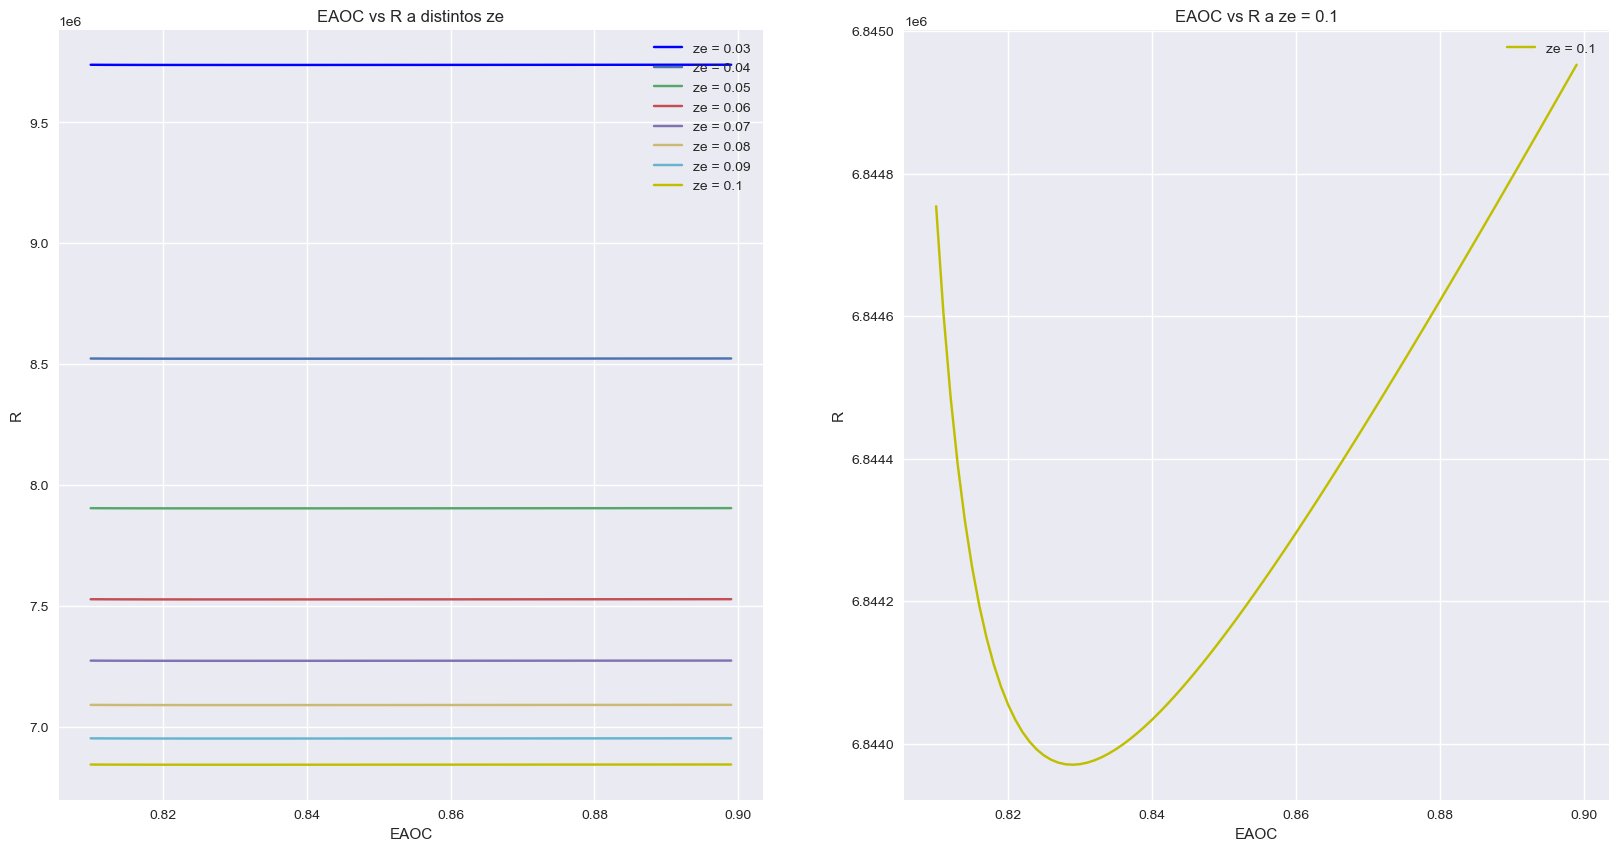

In [58]:
fig1, (axis1, axis2) = plt.subplots(1,2, figsize = (20,10))

axis1.plot(reflujo, df["ze = 0.03"], label='ze = 0.03', c ='b')
axis1.plot(reflujo, df["ze = 0.04"], label='ze = 0.04')
axis1.plot(reflujo, df["ze = 0.05"], label='ze = 0.05')
axis1.plot(reflujo, df["ze = 0.06"], label='ze = 0.06')
axis1.plot(reflujo, df["ze = 0.07"], label='ze = 0.07')
axis1.plot(reflujo, df["ze = 0.08"], label='ze = 0.08')
axis1.plot(reflujo, df["ze = 0.09"], label='ze = 0.09')
axis1.plot(reflujo, df["ze = 0.1"], label='ze = 0.1', c = 'y')
axis1.set_title("EAOC vs R a distintos ze")
axis1.set_xlabel("EAOC")
axis1.set_ylabel("R")


axis2.plot(reflujo, df["ze = 0.1"], label='ze = 0.1', c = 'y')
axis2.set_title("EAOC vs R a ze = 0.1")
axis2.set_xlabel("EAOC")
axis2.set_ylabel("R")

axis2.legend()
axis1.legend()

ind = df['ze = 0.1'].idxmin()
print(f"El EAOC minimo para xA = 0.3 es {round(df.loc[ind, 'ze = 0.1'],4)} $/yr con un = {ind} y ze = 0.1 ") 

# OPTIMIZACION FINAL 

In [77]:
# Valores fijos 
resultados_finales = [] # Tensor 
q = 1 

for c in np.arange(0.03, 0.1, 0.01): #Composición etanol  
    tensorfino = [] 
    resultados_finales.append(tensorfino)
    print(f"Iniciando iteración numero {q}...")
    q+= 1

    for i in np.arange(0.03, 0.5, 0.01): #Conversion (Ze)
        resultados = []
        tensorfino.append(resultados)
   
        for j in np.arange(0.81, 0.9, 0.001): #Reflujo 
            # Economía 
            tasai = 0.085   # Tasa de interés de la planta 
            n = 10          # Tiempo de evaluación 

            # Flujo volumetrico producción
            Q = 1e6*(3.78541)*(1/350)*(1/24)              # Produccion [L/h]

            # Propiedades fisicoquimicas del destilado
            dEtOH = 789                                    # Densidad etanol [kg/m3] 
            dH2O = 997                                     # Densidad agua [kg/m3]
            MEtOH = 46.068                                 # Peso molecular etanol [kg/kmol]
            MH2O = 18.015                                  # Peso molecular agua [kg/kmol]
            alfa = 3.5                                     # Volatilidad relativa mezcla 
            heatVap = 40.79*1000                           # Entalpía de vaporización del agua [kJ/kmol] 

            # Fracciones de recuperación del componente más volatil 
            ye = 0.95                                      # Fracción etanol en el tope 
            xe = 0.01                                      # Fraccion etanol en el fondo 

            mD = Q*(1/1000)*(dEtOH*ye + (1-ye)*dH2O)       # Flujo másico destilado [kg/h]
            D = mD/(MEtOH*ye + (1-ye)*MH2O)                # Flujo molar destilad [kmol/h]

            # Calculos de diseño -> FUG 
            V = (1 + j)*D                                  # Flujo molar vapor [kmol/h]
            F = ((ye - xe)/(c - xe))*D                    # Flujo molar alimentacion [kmol/h]
            Rmin = 2/(alfa - 1)                            # Relacion de reflujo 
            X = (j - Rmin)/(j + 1)
            Y = 1 - exp(((1 + 54.4*X)/(11 + 117.2*X))*(X - 1)/sqrt(X))
            Nmin = log((ye/xe)*(1-ye)/(1-xe))/log(alfa)    # Numero de etapas mínimas 
            N = (Y + Nmin)/(1 - Y)
            L = N                                          # Longitud de la columa [m]
            d = 0.15*sqrt(V)                               # Diametro de la columna [m]
            VC = (pi/4)*L*d**2                             # Volumen de la columa [m^3]


            # Costos: 
            PC_dist = 1.3*10000*VC**0.85                   # Precio de la columna 
            PC_dist = PC_dist*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1) 
            UC_cw = 3.54e-7*V*heatVap*(24*350)             # Precio del agua de enfriamiento [dol/yr]
            UC_s = UC_cw*20                                # Precio del servicio de calientamiento [dol/yr]


            # Temperatura de reacción 
            T = 35 + 273.15 # [K]
            MGluc = 180.16  # [kmol/kg]
            dGluc = 1560    # [kg/m3]

            # Calculos de diseño
            FEtOH = F*c    # [kmol/h]
            FH2O = F - FEtOH # [kmol/h]
            avance = FEtOH/2 # [kmol/h]

            # Calculo de flujos molares 
            FGluc0 = avance/i # [kmol/h]
            FH2O0 = FH2O       # [kmol/h]

            # Calculo de flujos másicas 
            mFeedH2O = FH2O0*MH2O   # [kg/h]
            mFeedGluc = FGluc0*MGluc # [kg/h]

            # Flujo volumetrico 
            V_feedH2O = mFeedH2O/dH2O # [m3/h]
            V_feedGluc = mFeedGluc/dGluc # [m3/h]

            # Flujos de alimento al fermentador
            Fin = FGluc0 + FH2O         # [kmol/h]
            Min = mFeedH2O + mFeedGluc  # [kg/h]
            V_feed = (V_feedH2O + V_feedGluc)*1000 # [L/h]

            k = 1.5*exp(-3500/T) # [s-1]
            tf = (1/k)*(1/(0.5 - i))  # [s]
            tf_total = (tf/3600) + 5   # [h]
            V_fermentador = V_feed*tf_total  # [L]

            # Costo del fermentador 
            PC_reactor = 7500*(V_fermentador**0.5)     # plata
            PC_reactor = PC_reactor*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1)   #plata/años

            # Costos utilidades 
            UC_CalF = (5e-6)*V_fermentador*(574.79/1000)*(24*350)   #plata/año
            UC_limp = 1000*(1 + 0.5*(V_fermentador/1000))

            # Parametros de diseño 
            F_corr = 0.8
            U = 500 # W/m2 k
            TmixIn = 150 #[°C] 
            TmixOut = 35 #[°C]
            TcIn = 25    #[°C]
            TcOut = 65   #[°C]
            Cp = 4.184*1000 #[J/kg °C]

            # Calculo de diseño
            M_mix = Min*(1/3600) #Kg/s
            dTml = ((TmixOut-TcIn)-(TmixIn-TcOut))/log((TmixOut-TcIn)/(TmixIn-TcOut))
            Q_I = M_mix*Cp*(TmixIn - TmixOut)
            A = Q/(U*F*dTml)

            # Costo intercambiador 
            PC_hx = 12000*(A**0.67)
            PC_hx = PC_hx*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1) 

            #Servicios 
            UC_CWHx = (5e-6)*(Q_I*(3600/1000)*(24*350))

            # Precio del molino
            mAlmidon = (mFeedGluc/0.9) #[kg/h]
            mMaiz = mAlmidon/0.65 #[kg/h]
            dMaiz = 700 
            Cslurry = 0.15 

            mAgua = (mMaiz*(1 - Cslurry))/Cslurry #kg/h
            Qagua = mAgua/dH2O  #m3/h

            Qmaiz = mMaiz/dMaiz #m3/h 
            Vfeed = (Qagua + Qmaiz)*(1000) # L/h

            # Costo suministro de agua
            tmill = 12/60    # h 
            Vmill = 1.2*Vfeed*tmill #L

            # Precio del equipo 
            PCmill = 5000*Vmill**0.42
            PCmill = PCmill*(tasai*(tasai + 1)**n)/((1 + tasai)**n - 1)

            # Precio suministros 
            UCwater = 100/1000*(Qagua*24*350)

            mEnzimas = mAlmidon #Unidades 
            PEnzimas = (75/10000)*mEnzimas*24*350

            # Costo de hidrolización 
            UCheatingH = 5e-6*Vmill*(0.932/10)

            PrecioMaiz = (4/25.40)*mMaiz*24*365
            EAOC = PC_dist + UC_cw + UC_s + PC_reactor + UC_CalF + UC_limp + PC_hx + UC_CWHx + PCmill + UCwater + PEnzimas + UCheatingH + PrecioMaiz
            resultados.append(EAOC)

Iniciando iteración numero 1...
Iniciando iteración numero 2...
Iniciando iteración numero 3...
Iniciando iteración numero 4...
Iniciando iteración numero 5...
Iniciando iteración numero 6...
Iniciando iteración numero 7...
Iniciando iteración numero 8...


In [78]:
# Definir los valores posibles de Composicion Etanol (c)
valores_c = np.arange(0.03, 0.1, 0.01)

# Definir los valores posibles de Conversion (i)
valores_i = np.arange(0.03, 0.5, 0.01)

# Definir los valores posibles de Reflujo (R)
valores_R = np.arange(0.81, 0.9, 0.001)

dataframes = []

# Inicializar un diccionario de datos
data = {'Reflujo (j)': valores_R}

# Crear y mostrar una tabla para cada valor de c
for c_index, c in enumerate(valores_c):
    # Crear un DataFrame vacío para cada valor de c
    df = pd.DataFrame(data)
    
    for i_index, i in enumerate(valores_i):
        # Extraer los valores de EAOC correspondientes a c y i
        valores_EAOC = resultados_finales[c_index][i_index]
        
        # Agregar los valores de EAOC como una nueva columna en el DataFrame
        df[f'Conversion (i) = {i:.2f}'] = valores_EAOC
    
    # Establecer la columna 'Reflujo (j)' como índice
    df.set_index('Reflujo (j)', inplace=True)
    
    # Mostrar el DataFrame para el valor de c actual
    dataframes.append(df)


## VALORES ÓPTIMOS

In [79]:
minimo_valor_global = float('inf')
minimo_c = None
minimo_i = None
minimo_j = None

# Recorrer los resultados_finales
for c_index, resultados_c in enumerate(resultados_finales):
    for i_index, resultados_i in enumerate(resultados_c):
        for j_index, eaoc in enumerate(resultados_i):
            if eaoc < minimo_valor_global:
                minimo_valor_global = eaoc
                minimo_c = np.arange(0.03, 0.1, 0.01)[c_index]
                minimo_i = np.arange(0.03, 0.5, 0.01)[i_index]
                minimo_j = np.arange(0.81, 0.9, 0.001)[j_index]

# Mostrar los resultados
print(f"El valor mínimo global de EAOC es {minimo_valor_global} y se encuentra en la combinación de valores:")
print(f"Ze = {minimo_c:.2f}")
print(f"X = {minimo_i:.2f}")
print(f"R = {minimo_j:.3f}")

El valor mínimo global de EAOC es 5605347.753919953 y se encuentra en la combinación de valores:
Ze = 0.10
X = 0.43
R = 0.829


# RESULTADOS PARA Ze = 0.03 

In [61]:
dataframes[0]

,Conversion (i) = 0.03,Conversion (i) = 0.04,Conversion (i) = 0.05,Conversion (i) = 0.06,Conversion (i) = 0.07,Conversion (i) = 0.08,Conversion (i) = 0.09,Conversion (i) = 0.10,Conversion (i) = 0.11,Conversion (i) = 0.12,...,Conversion (i) = 0.40,Conversion (i) = 0.41,Conversion (i) = 0.42,Conversion (i) = 0.43,Conversion (i) = 0.44,Conversion (i) = 0.45,Conversion (i) = 0.46,Conversion (i) = 0.47,Conversion (i) = 0.48,Conversion (i) = 0.49
Reflujo (j),,,,,,,,,,,,,,,,,,,,,
0.810,8.354684e+07,6.294909e+07,5.058659e+07,4.234419e+07,3.645738e+07,3.204358e+07,2.861228e+07,2.586911e+07,2.362669e+07,2.176008e+07,...,8.361948e+06,8.351741e+06,8.379665e+06,8.457444e+06,8.604545e+06,8.855543e+06,9.278116e+06,1.002569e+07,1.154159e+07,1.592858e+07
0.811,8.354670e+07,6.294894e+07,5.058645e+07,4.234404e+07,3.645723e+07,3.204343e+07,2.861213e+07,2.586896e+07,2.362654e+07,2.175993e+07,...,8.361800e+06,8.351593e+06,8.379517e+06,8.457296e+06,8.604397e+06,8.855395e+06,9.277968e+06,1.002554e+07,1.154144e+07,1.592843e+07
0.812,8.354658e+07,6.294882e+07,5.058633e+07,4.234392e+07,3.645711e+07,3.204331e+07,2.861201e+07,2.586884e+07,2.362642e+07,2.175982e+07,...,8.361681e+06,8.351474e+06,8.379399e+06,8.457178e+06,8.604279e+06,8.855276e+06,9.277850e+06,1.002543e+07,1.154132e+07,1.592831e+07
0.813,8.354648e+07,6.294873e+07,5.058623e+07,4.234382e+07,3.645702e+07,3.204321e+07,2.861192e+07,2.586874e+07,2.362632e+07,2.175972e+07,...,8.361585e+06,8.351378e+06,8.379303e+06,8.457081e+06,8.604183e+06,8.855180e+06,9.277753e+06,1.002533e+07,1.154123e+07,1.592822e+07
0.814,8.354640e+07,6.294865e+07,5.058615e+07,4.234375e+07,3.645694e+07,3.204314e+07,2.861184e+07,2.586866e+07,2.362624e+07,2.175964e+07,...,8.361506e+06,8.351299e+06,8.379224e+06,8.457003e+06,8.604104e+06,8.855101e+06,9.277675e+06,1.002525e+07,1.154115e+07,1.592814e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.895,8.354697e+07,6.294922e+07,5.058672e+07,4.234431e+07,3.645751e+07,3.204370e+07,2.861241e+07,2.586923e+07,2.362681e+07,2.176021e+07,...,8.362075e+06,8.351868e+06,8.379793e+06,8.457572e+06,8.604673e+06,8.855671e+06,9.278244e+06,1.002582e+07,1.154172e+07,1.592871e+07
0.896,8.354699e+07,6.294923e+07,5.058674e+07,4.234433e+07,3.645753e+07,3.204372e+07,2.861242e+07,2.586925e+07,2.362683e+07,2.176023e+07,...,8.362093e+06,8.351886e+06,8.379811e+06,8.457589e+06,8.604691e+06,8.855688e+06,9.278261e+06,1.002584e+07,1.154173e+07,1.592872e+07
0.897,8.354701e+07,6.294925e+07,5.058676e+07,4.234435e+07,3.645754e+07,3.204374e+07,2.861244e+07,2.586927e+07,2.362685e+07,2.176025e+07,...,8.362111e+06,8.351904e+06,8.379828e+06,8.457607e+06,8.604708e+06,8.855706e+06,9.278279e+06,1.002586e+07,1.154175e+07,1.592874e+07


# RESULTADOS PARA Ze = 0.04 

In [62]:
dataframes[1]

,Conversion (i) = 0.03,Conversion (i) = 0.04,Conversion (i) = 0.05,Conversion (i) = 0.06,Conversion (i) = 0.07,Conversion (i) = 0.08,Conversion (i) = 0.09,Conversion (i) = 0.10,Conversion (i) = 0.11,Conversion (i) = 0.12,...,Conversion (i) = 0.40,Conversion (i) = 0.41,Conversion (i) = 0.42,Conversion (i) = 0.43,Conversion (i) = 0.44,Conversion (i) = 0.45,Conversion (i) = 0.46,Conversion (i) = 0.47,Conversion (i) = 0.48,Conversion (i) = 0.49
Reflujo (j),,,,,,,,,,,,,,,,,,,,,
0.810,7.424327e+07,5.592250e+07,4.492506e+07,3.759171e+07,3.235338e+07,2.842517e+07,2.537086e+07,2.292862e+07,2.093181e+07,1.926928e+07,...,7.212961e+06,7.185797e+06,7.188341e+06,7.229267e+06,7.323003e+06,7.495144e+06,7.795687e+06,8.337572e+06,9.445499e+06,1.264805e+07
0.811,7.424312e+07,5.592236e+07,4.492491e+07,3.759156e+07,3.235323e+07,2.842502e+07,2.537071e+07,2.292848e+07,2.093166e+07,1.926914e+07,...,7.212813e+06,7.185650e+06,7.188193e+06,7.229119e+06,7.322855e+06,7.494996e+06,7.795539e+06,8.337424e+06,9.445351e+06,1.264791e+07
0.812,7.424301e+07,5.592224e+07,4.492479e+07,3.759144e+07,3.235311e+07,2.842490e+07,2.537059e+07,2.292836e+07,2.093154e+07,1.926902e+07,...,7.212694e+06,7.185531e+06,7.188074e+06,7.229001e+06,7.322736e+06,7.494878e+06,7.795421e+06,8.337305e+06,9.445233e+06,1.264779e+07
0.813,7.424291e+07,5.592214e+07,4.492469e+07,3.759134e+07,3.235301e+07,2.842480e+07,2.537049e+07,2.292826e+07,2.093145e+07,1.926892e+07,...,7.212598e+06,7.185435e+06,7.187978e+06,7.228905e+06,7.322640e+06,7.494782e+06,7.795325e+06,8.337209e+06,9.445136e+06,1.264769e+07
0.814,7.424283e+07,5.592206e+07,4.492462e+07,3.759127e+07,3.235293e+07,2.842473e+07,2.537042e+07,2.292818e+07,2.093137e+07,1.926884e+07,...,7.212519e+06,7.185356e+06,7.187899e+06,7.228826e+06,7.322561e+06,7.494703e+06,7.795246e+06,8.337130e+06,9.445058e+06,1.264761e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.895,7.424340e+07,5.592263e+07,4.492518e+07,3.759184e+07,3.235350e+07,2.842529e+07,2.537098e+07,2.292875e+07,2.093194e+07,1.926941e+07,...,7.213088e+06,7.185925e+06,7.188468e+06,7.229395e+06,7.323131e+06,7.495272e+06,7.795815e+06,8.337699e+06,9.445627e+06,1.264818e+07
0.896,7.424342e+07,5.592265e+07,4.492520e+07,3.759185e+07,3.235352e+07,2.842531e+07,2.537100e+07,2.292877e+07,2.093196e+07,1.926943e+07,...,7.213106e+06,7.185943e+06,7.188486e+06,7.229413e+06,7.323148e+06,7.495290e+06,7.795833e+06,8.337717e+06,9.445644e+06,1.264820e+07
0.897,7.424344e+07,5.592267e+07,4.492522e+07,3.759187e+07,3.235354e+07,2.842533e+07,2.537102e+07,2.292879e+07,2.093197e+07,1.926945e+07,...,7.213124e+06,7.185961e+06,7.188504e+06,7.229431e+06,7.323166e+06,7.495308e+06,7.795851e+06,8.337735e+06,9.445662e+06,1.264822e+07


# RESULTADOS PARA Ze = 0.05

In [63]:
dataframes[2]

,Conversion (i) = 0.03,Conversion (i) = 0.04,Conversion (i) = 0.05,Conversion (i) = 0.06,Conversion (i) = 0.07,Conversion (i) = 0.08,Conversion (i) = 0.09,Conversion (i) = 0.10,Conversion (i) = 0.11,Conversion (i) = 0.12,...,Conversion (i) = 0.40,Conversion (i) = 0.41,Conversion (i) = 0.42,Conversion (i) = 0.43,Conversion (i) = 0.44,Conversion (i) = 0.45,Conversion (i) = 0.46,Conversion (i) = 0.47,Conversion (i) = 0.48,Conversion (i) = 0.49
Reflujo (j),,,,,,,,,,,,,,,,,,,,,
0.810,6.958753e+07,5.240499e+07,4.208978e+07,3.521067e+07,3.029628e+07,2.661059e+07,2.374449e+07,2.145246e+07,1.957818e+07,1.801743e+07,...,6.621410e+06,6.584780e+06,6.573473e+06,6.594581e+06,6.659916e+06,6.790431e+06,7.026992e+06,7.461701e+06,8.358405e+06,1.095245e+07
0.811,6.958739e+07,5.240484e+07,4.208963e+07,3.521052e+07,3.029613e+07,2.661044e+07,2.374434e+07,2.145231e+07,1.957803e+07,1.801728e+07,...,6.621262e+06,6.584632e+06,6.573325e+06,6.594433e+06,6.659768e+06,6.790283e+06,7.026845e+06,7.461553e+06,8.358257e+06,1.095231e+07
0.812,6.958727e+07,5.240473e+07,4.208951e+07,3.521040e+07,3.029602e+07,2.661032e+07,2.374423e+07,2.145219e+07,1.957791e+07,1.801717e+07,...,6.621143e+06,6.584514e+06,6.573206e+06,6.594315e+06,6.659650e+06,6.790164e+06,7.026726e+06,7.461434e+06,8.358139e+06,1.095219e+07
0.813,6.958717e+07,5.240463e+07,4.208942e+07,3.521030e+07,3.029592e+07,2.661022e+07,2.374413e+07,2.145209e+07,1.957782e+07,1.801707e+07,...,6.621047e+06,6.584418e+06,6.573110e+06,6.594219e+06,6.659554e+06,6.790068e+06,7.026630e+06,7.461338e+06,8.358043e+06,1.095209e+07
0.814,6.958709e+07,5.240455e+07,4.208934e+07,3.521022e+07,3.029584e+07,2.661014e+07,2.374405e+07,2.145202e+07,1.957774e+07,1.801699e+07,...,6.620968e+06,6.584339e+06,6.573031e+06,6.594140e+06,6.659475e+06,6.789989e+06,7.026551e+06,7.461259e+06,8.357964e+06,1.095201e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.895,6.958766e+07,5.240512e+07,4.208991e+07,3.521079e+07,3.029641e+07,2.661071e+07,2.374462e+07,2.145259e+07,1.957831e+07,1.801756e+07,...,6.621537e+06,6.584908e+06,6.573601e+06,6.594709e+06,6.660044e+06,6.790558e+06,7.027120e+06,7.461829e+06,8.358533e+06,1.095258e+07
0.896,6.958768e+07,5.240514e+07,4.208993e+07,3.521081e+07,3.029643e+07,2.661073e+07,2.374464e+07,2.145260e+07,1.957833e+07,1.801758e+07,...,6.621555e+06,6.584926e+06,6.573618e+06,6.594727e+06,6.660062e+06,6.790576e+06,7.027138e+06,7.461846e+06,8.358551e+06,1.095260e+07
0.897,6.958770e+07,5.240515e+07,4.208994e+07,3.521083e+07,3.029645e+07,2.661075e+07,2.374466e+07,2.145262e+07,1.957834e+07,1.801759e+07,...,6.621573e+06,6.584943e+06,6.573636e+06,6.594744e+06,6.660079e+06,6.790594e+06,7.027156e+06,7.461864e+06,8.358569e+06,1.095262e+07


# RESULTADOS PARA Ze = 0.06

In [64]:
dataframes[3]

,Conversion (i) = 0.03,Conversion (i) = 0.04,Conversion (i) = 0.05,Conversion (i) = 0.06,Conversion (i) = 0.07,Conversion (i) = 0.08,Conversion (i) = 0.09,Conversion (i) = 0.10,Conversion (i) = 0.11,Conversion (i) = 0.12,...,Conversion (i) = 0.40,Conversion (i) = 0.41,Conversion (i) = 0.42,Conversion (i) = 0.43,Conversion (i) = 0.44,Conversion (i) = 0.45,Conversion (i) = 0.46,Conversion (i) = 0.47,Conversion (i) = 0.48,Conversion (i) = 0.49
Reflujo (j),,,,,,,,,,,,,,,,,,,,,
0.810,6.679258e+07,5.029285e+07,4.038684e+07,3.378012e+07,2.905997e+07,2.551964e+07,2.276634e+07,2.056429e+07,1.876340e+07,1.726358e+07,...,6.258450e+06,6.215660e+06,6.195479e+06,6.204023e+06,6.251488e+06,6.355965e+06,6.552711e+06,6.921033e+06,7.687530e+06,9.908670e+06
0.811,6.679243e+07,5.029270e+07,4.038669e+07,3.377998e+07,2.905982e+07,2.551949e+07,2.276619e+07,2.056414e+07,1.876325e+07,1.726344e+07,...,6.258302e+06,6.215512e+06,6.195332e+06,6.203875e+06,6.251340e+06,6.355818e+06,6.552563e+06,6.920885e+06,7.687382e+06,9.908522e+06
0.812,6.679232e+07,5.029258e+07,4.038657e+07,3.377986e+07,2.905970e+07,2.551937e+07,2.276607e+07,2.056402e+07,1.876313e+07,1.726332e+07,...,6.258183e+06,6.215394e+06,6.195213e+06,6.203757e+06,6.251222e+06,6.355699e+06,6.552444e+06,6.920766e+06,7.687264e+06,9.908404e+06
0.813,6.679222e+07,5.029248e+07,4.038648e+07,3.377976e+07,2.905961e+07,2.551928e+07,2.276598e+07,2.056392e+07,1.876304e+07,1.726322e+07,...,6.258087e+06,6.215298e+06,6.195117e+06,6.203660e+06,6.251125e+06,6.355603e+06,6.552348e+06,6.920670e+06,7.687168e+06,9.908307e+06
0.814,6.679214e+07,5.029241e+07,4.038640e+07,3.377968e+07,2.905953e+07,2.551920e+07,2.276590e+07,2.056385e+07,1.876296e+07,1.726314e+07,...,6.258008e+06,6.215219e+06,6.195038e+06,6.203582e+06,6.251046e+06,6.355524e+06,6.552269e+06,6.920591e+06,7.687089e+06,9.908229e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.895,6.679271e+07,5.029298e+07,4.038697e+07,3.378025e+07,2.906010e+07,2.551977e+07,2.276647e+07,2.056441e+07,1.876353e+07,1.726371e+07,...,6.258578e+06,6.215788e+06,6.195607e+06,6.204151e+06,6.251616e+06,6.356093e+06,6.552838e+06,6.921160e+06,7.687658e+06,9.908798e+06
0.896,6.679273e+07,5.029299e+07,4.038698e+07,3.378027e+07,2.906011e+07,2.551979e+07,2.276648e+07,2.056443e+07,1.876354e+07,1.726373e+07,...,6.258595e+06,6.215806e+06,6.195625e+06,6.204169e+06,6.251633e+06,6.356111e+06,6.552856e+06,6.921178e+06,7.687676e+06,9.908816e+06
0.897,6.679275e+07,5.029301e+07,4.038700e+07,3.378029e+07,2.906013e+07,2.551980e+07,2.276650e+07,2.056445e+07,1.876356e+07,1.726375e+07,...,6.258613e+06,6.215824e+06,6.195643e+06,6.204186e+06,6.251651e+06,6.356129e+06,6.552874e+06,6.921196e+06,7.687693e+06,9.908833e+06


# RESULTADOS PARA Ze = 0.07

In [65]:
dataframes[4]

,Conversion (i) = 0.03,Conversion (i) = 0.04,Conversion (i) = 0.05,Conversion (i) = 0.06,Conversion (i) = 0.07,Conversion (i) = 0.08,Conversion (i) = 0.09,Conversion (i) = 0.10,Conversion (i) = 0.11,Conversion (i) = 0.12,...,Conversion (i) = 0.40,Conversion (i) = 0.41,Conversion (i) = 0.42,Conversion (i) = 0.43,Conversion (i) = 0.44,Conversion (i) = 0.45,Conversion (i) = 0.46,Conversion (i) = 0.47,Conversion (i) = 0.48,Conversion (i) = 0.49
Reflujo (j),,,,,,,,,,,,,,,,,,,,,
0.810,6.492858e+07,4.888398e+07,3.925070e+07,3.282551e+07,2.823476e+07,2.479127e+07,2.211309e+07,1.997095e+07,1.821891e+07,1.675965e+07,...,6.012078e+06,5.964911e+06,5.938498e+06,5.938287e+06,5.973373e+06,6.059899e+06,6.229301e+06,6.552205e+06,7.229962e+06,9.198153e+06
0.811,6.492843e+07,4.888383e+07,3.925055e+07,3.282536e+07,2.823461e+07,2.479112e+07,2.211294e+07,1.997080e+07,1.821876e+07,1.675950e+07,...,6.011930e+06,5.964763e+06,5.938350e+06,5.938139e+06,5.973225e+06,6.059751e+06,6.229154e+06,6.552057e+06,7.229814e+06,9.198005e+06
0.812,6.492831e+07,4.888371e+07,3.925043e+07,3.282524e+07,2.823450e+07,2.479100e+07,2.211282e+07,1.997068e+07,1.821864e+07,1.675938e+07,...,6.011811e+06,5.964644e+06,5.938231e+06,5.938020e+06,5.973106e+06,6.059632e+06,6.229035e+06,6.551938e+06,7.229696e+06,9.197887e+06
0.813,6.492822e+07,4.888362e+07,3.925034e+07,3.282515e+07,2.823440e+07,2.479091e+07,2.211272e+07,1.997059e+07,1.821855e+07,1.675928e+07,...,6.011715e+06,5.964548e+06,5.938135e+06,5.937924e+06,5.973010e+06,6.059536e+06,6.228939e+06,6.551842e+06,7.229599e+06,9.197790e+06
0.814,6.492814e+07,4.888354e+07,3.925026e+07,3.282507e+07,2.823432e+07,2.479083e+07,2.211264e+07,1.997051e+07,1.821847e+07,1.675920e+07,...,6.011636e+06,5.964469e+06,5.938056e+06,5.937845e+06,5.972931e+06,6.059457e+06,6.228860e+06,6.551763e+06,7.229521e+06,9.197712e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.895,6.492871e+07,4.888411e+07,3.925083e+07,3.282564e+07,2.823489e+07,2.479140e+07,2.211321e+07,1.997108e+07,1.821904e+07,1.675977e+07,...,6.012206e+06,5.965039e+06,5.938626e+06,5.938414e+06,5.973501e+06,6.060027e+06,6.229429e+06,6.552333e+06,7.230090e+06,9.198281e+06
0.896,6.492873e+07,4.888413e+07,3.925085e+07,3.282566e+07,2.823491e+07,2.479142e+07,2.211323e+07,1.997109e+07,1.821906e+07,1.675979e+07,...,6.012223e+06,5.965056e+06,5.938643e+06,5.938432e+06,5.973518e+06,6.060044e+06,6.229447e+06,6.552350e+06,7.230108e+06,9.198298e+06
0.897,6.492874e+07,4.888414e+07,3.925086e+07,3.282567e+07,2.823493e+07,2.479143e+07,2.211325e+07,1.997111e+07,1.821907e+07,1.675981e+07,...,6.012241e+06,5.965074e+06,5.938661e+06,5.938450e+06,5.973536e+06,6.060062e+06,6.229465e+06,6.552368e+06,7.230125e+06,9.198316e+06


# RESULTADOS PARA Ze = 0.08

In [66]:
dataframes[5]

,Conversion (i) = 0.03,Conversion (i) = 0.04,Conversion (i) = 0.05,Conversion (i) = 0.06,Conversion (i) = 0.07,Conversion (i) = 0.08,Conversion (i) = 0.09,Conversion (i) = 0.10,Conversion (i) = 0.11,Conversion (i) = 0.12,...,Conversion (i) = 0.40,Conversion (i) = 0.41,Conversion (i) = 0.42,Conversion (i) = 0.43,Conversion (i) = 0.44,Conversion (i) = 0.45,Conversion (i) = 0.46,Conversion (i) = 0.47,Conversion (i) = 0.48,Conversion (i) = 0.49
Reflujo (j),,,,,,,,,,,,,,,,,,,,,
0.810,6.359678e+07,4.787724e+07,3.843872e+07,3.214315e+07,2.764479e+07,2.427042e+07,2.164584e+07,1.954646e+07,1.782927e+07,1.639892e+07,...,5.833442e+06,5.782981e+06,5.751921e+06,5.745223e+06,5.771181e+06,5.844519e+06,5.993901e+06,6.283650e+06,6.896834e+06,8.681688e+06
0.811,6.359663e+07,4.787709e+07,3.843857e+07,3.214300e+07,2.764464e+07,2.427027e+07,2.164570e+07,1.954631e+07,1.782912e+07,1.639877e+07,...,5.833294e+06,5.782833e+06,5.751773e+06,5.745075e+06,5.771033e+06,5.844371e+06,5.993753e+06,6.283502e+06,6.896687e+06,8.681540e+06
0.812,6.359651e+07,4.787697e+07,3.843845e+07,3.214288e+07,2.764452e+07,2.427015e+07,2.164558e+07,1.954619e+07,1.782900e+07,1.639865e+07,...,5.833176e+06,5.782715e+06,5.751655e+06,5.744957e+06,5.770914e+06,5.844253e+06,5.993634e+06,6.283383e+06,6.896568e+06,8.681422e+06
0.813,6.359642e+07,4.787688e+07,3.843836e+07,3.214278e+07,2.764442e+07,2.427005e+07,2.164548e+07,1.954609e+07,1.782890e+07,1.639856e+07,...,5.833080e+06,5.782619e+06,5.751559e+06,5.744860e+06,5.770818e+06,5.844156e+06,5.993538e+06,6.283287e+06,6.896472e+06,8.681325e+06
0.814,6.359634e+07,4.787680e+07,3.843828e+07,3.214270e+07,2.764435e+07,2.426998e+07,2.164540e+07,1.954601e+07,1.782882e+07,1.639848e+07,...,5.833001e+06,5.782540e+06,5.751480e+06,5.744782e+06,5.770739e+06,5.844078e+06,5.993459e+06,6.283208e+06,6.896393e+06,8.681247e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.895,6.359691e+07,4.787737e+07,3.843885e+07,3.214327e+07,2.764491e+07,2.427055e+07,2.164597e+07,1.954658e+07,1.782939e+07,1.639905e+07,...,5.833570e+06,5.783109e+06,5.752049e+06,5.745351e+06,5.771309e+06,5.844647e+06,5.994029e+06,6.283777e+06,6.896962e+06,8.681816e+06
0.896,6.359693e+07,4.787738e+07,3.843887e+07,3.214329e+07,2.764493e+07,2.427056e+07,2.164599e+07,1.954660e+07,1.782941e+07,1.639906e+07,...,5.833588e+06,5.783127e+06,5.752067e+06,5.745369e+06,5.771326e+06,5.844664e+06,5.994046e+06,6.283795e+06,6.896980e+06,8.681833e+06
0.897,6.359694e+07,4.787740e+07,3.843888e+07,3.214331e+07,2.764495e+07,2.427058e+07,2.164601e+07,1.954662e+07,1.782943e+07,1.639908e+07,...,5.833605e+06,5.783145e+06,5.752085e+06,5.745386e+06,5.771344e+06,5.844682e+06,5.994064e+06,6.283813e+06,6.896998e+06,8.681851e+06


# RESULTADOS PARA Ze = 0.09

In [67]:
dataframes[6]

,Conversion (i) = 0.03,Conversion (i) = 0.04,Conversion (i) = 0.05,Conversion (i) = 0.06,Conversion (i) = 0.07,Conversion (i) = 0.08,Conversion (i) = 0.09,Conversion (i) = 0.10,Conversion (i) = 0.11,Conversion (i) = 0.12,...,Conversion (i) = 0.40,Conversion (i) = 0.41,Conversion (i) = 0.42,Conversion (i) = 0.43,Conversion (i) = 0.44,Conversion (i) = 0.45,Conversion (i) = 0.46,Conversion (i) = 0.47,Conversion (i) = 0.48,Conversion (i) = 0.49
Reflujo (j),,,,,,,,,,,,,,,,,,,,,
0.810,6.259772e+07,4.712194e+07,3.782947e+07,3.163108e+07,2.720198e+07,2.387943e+07,2.129503e+07,1.922768e+07,1.753660e+07,1.612791e+07,...,5.697750e+06,5.644708e+06,5.610034e+06,5.598316e+06,5.617239e+06,5.680446e+06,5.814491e+06,6.078906e+06,6.642884e+06,8.288493e+06
0.811,6.259757e+07,4.712179e+07,3.782932e+07,3.163093e+07,2.720184e+07,2.387928e+07,2.129489e+07,1.922753e+07,1.753645e+07,1.612776e+07,...,5.697602e+06,5.644560e+06,5.609886e+06,5.598168e+06,5.617091e+06,5.680298e+06,5.814343e+06,6.078758e+06,6.642736e+06,8.288346e+06
0.812,6.259745e+07,4.712168e+07,3.782920e+07,3.163081e+07,2.720172e+07,2.387916e+07,2.129477e+07,1.922741e+07,1.753633e+07,1.612764e+07,...,5.697483e+06,5.644441e+06,5.609767e+06,5.598050e+06,5.616972e+06,5.680180e+06,5.814224e+06,6.078639e+06,6.642617e+06,8.288227e+06
0.813,6.259736e+07,4.712158e+07,3.782911e+07,3.163072e+07,2.720162e+07,2.387906e+07,2.129467e+07,1.922732e+07,1.753623e+07,1.612755e+07,...,5.697387e+06,5.644345e+06,5.609671e+06,5.597954e+06,5.616876e+06,5.680084e+06,5.814128e+06,6.078543e+06,6.642521e+06,8.288131e+06
0.814,6.259728e+07,4.712150e+07,3.782903e+07,3.163064e+07,2.720154e+07,2.387899e+07,2.129459e+07,1.922724e+07,1.753615e+07,1.612747e+07,...,5.697308e+06,5.644266e+06,5.609592e+06,5.597875e+06,5.616797e+06,5.680005e+06,5.814049e+06,6.078464e+06,6.642442e+06,8.288052e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.895,6.259785e+07,4.712207e+07,3.782960e+07,3.163121e+07,2.720211e+07,2.387956e+07,2.129516e+07,1.922781e+07,1.753672e+07,1.612804e+07,...,5.697878e+06,5.644836e+06,5.610161e+06,5.598444e+06,5.617367e+06,5.680574e+06,5.814618e+06,6.079033e+06,6.643011e+06,8.288621e+06
0.896,6.259786e+07,4.712209e+07,3.782962e+07,3.163122e+07,2.720213e+07,2.387957e+07,2.129518e+07,1.922782e+07,1.753674e+07,1.612805e+07,...,5.697895e+06,5.644853e+06,5.610179e+06,5.598462e+06,5.617384e+06,5.680592e+06,5.814636e+06,6.079051e+06,6.643029e+06,8.288639e+06
0.897,6.259788e+07,4.712211e+07,3.782963e+07,3.163124e+07,2.720215e+07,2.387959e+07,2.129520e+07,1.922784e+07,1.753676e+07,1.612807e+07,...,5.697913e+06,5.644871e+06,5.610197e+06,5.598479e+06,5.617402e+06,5.680609e+06,5.814654e+06,6.079069e+06,6.643047e+06,8.288657e+06


# RESULTADOS PARA Ze = 0.1

In [76]:
dataframes[7]

,Conversion (i) = 0.03,Conversion (i) = 0.04,Conversion (i) = 0.05,Conversion (i) = 0.06,Conversion (i) = 0.07,Conversion (i) = 0.08,Conversion (i) = 0.09,Conversion (i) = 0.10,Conversion (i) = 0.11,Conversion (i) = 0.12,Conversion (i) = 0.13,Conversion (i) = 0.14,Conversion (i) = 0.15,Conversion (i) = 0.16,Conversion (i) = 0.17,Conversion (i) = 0.18,Conversion (i) = 0.19,Conversion (i) = 0.20,Conversion (i) = 0.21,Conversion (i) = 0.22,Conversion (i) = 0.23,Conversion (i) = 0.24,Conversion (i) = 0.25,Conversion (i) = 0.26,Conversion (i) = 0.27,Conversion (i) = 0.28,Conversion (i) = 0.29,Conversion (i) = 0.30,Conversion (i) = 0.31,Conversion (i) = 0.32,Conversion (i) = 0.33,Conversion (i) = 0.34,Conversion (i) = 0.35,Conversion (i) = 0.36,Conversion (i) = 0.37,Conversion (i) = 0.38,Conversion (i) = 0.39,Conversion (i) = 0.40,Conversion (i) = 0.41,Conversion (i) = 0.42,Conversion (i) = 0.43,Conversion (i) = 0.44,Conversion (i) = 0.45,Conversion (i) = 0.46,Conversion (i) = 0.47,Conversion (i) = 0.48,Conversion (i) = 0.49
Reflujo (j),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.810,6.182054e+07,4.653434e+07,3.735544e+07,3.123262e+07,2.685738e+07,2.357510e+07,2.102194e+07,1.897948e+07,1.730868e+07,1.591682e+07,1.473968e+07,1.373139e+07,1.285830e+07,1.209516e+07,1.142270e+07,1.082589e+07,1.029291e+07,9.814283e+06,9.382360e+06,8.990890e+06,8.634724e+06,8.309582e+06,8.011888e+06,7.738635e+06,7.487285e+06,7.255688e+06,7.042025e+06,6.844754e+06,6.662582e+06,6.494429e+06,6.339420e+06,6.196865e+06,6.066269e+06,5.947330e+06,5.839971e+06,5.744379e+06,5.661077e+06,5.591045e+06,5.535919e+06,5.498344e+06,5.482617e+06,5.495937e+06,5.551099e+06,5.672992e+06,5.917381e+06,6.442552e+06,7.978663e+06
0.811,6.182039e+07,4.653419e+07,3.735529e+07,3.123247e+07,2.685723e+07,2.357495e+07,2.102179e+07,1.897933e+07,1.730854e+07,1.591667e+07,1.473954e+07,1.373124e+07,1.285815e+07,1.209502e+07,1.142255e+07,1.082575e+07,1.029276e+07,9.814135e+06,9.382212e+06,8.990743e+06,8.634576e+06,8.309434e+06,8.011740e+06,7.738487e+06,7.487137e+06,7.255540e+06,7.041877e+06,6.844606e+06,6.662434e+06,6.494281e+06,6.339272e+06,6.196717e+06,6.066121e+06,5.947182e+06,5.839823e+06,5.744231e+06,5.660929e+06,5.590897e+06,5.535771e+06,5.498196e+06,5.482469e+06,5.495789e+06,5.550951e+06,5.672844e+06,5.917233e+06,6.442404e+06,7.978515e+06
0.812,6.182027e+07,4.653408e+07,3.735518e+07,3.123235e+07,2.685711e+07,2.357484e+07,2.102167e+07,1.897921e+07,1.730842e+07,1.591656e+07,1.473942e+07,1.373112e+07,1.285803e+07,1.209490e+07,1.142243e+07,1.082563e+07,1.029264e+07,9.814016e+06,9.382093e+06,8.990624e+06,8.634457e+06,8.309315e+06,8.011621e+06,7.738369e+06,7.487018e+06,7.255422e+06,7.041758e+06,6.844488e+06,6.662315e+06,6.494163e+06,6.339153e+06,6.196599e+06,6.066002e+06,5.947063e+06,5.839704e+06,5.744112e+06,5.660811e+06,5.590778e+06,5.535652e+06,5.498078e+06,5.482350e+06,5.495671e+06,5.550833e+06,5.672726e+06,5.917115e+06,6.442285e+06,7.978397e+06
0.813,6.182017e+07,4.653398e+07,3.735508e+07,3.123226e+07,2.685702e+07,2.357474e+07,2.102158e+07,1.897912e+07,1.730832e+07,1.591646e+07,1.473932e+07,1.373103e+07,1.285793e+07,1.209480e+07,1.142234e+07,1.082553e+07,1.029255e+07,9.813920e+06,9.381997e+06,8.990528e+06,8.634361e+06,8.309219e+06,8.011525e+06,7.738272e+06,7.486922e+06,7.255326e+06,7.041662e+06,6.844392e+06,6.662219e+06,6.494066e+06,6.339057e+06,6.196503e+06,6.065906e+06,5.946967e+06,5.839608e+06,5.744016e+06,5.660715e+06,5.590682e+06,5.535556e+06,5.497981e+06,5.482254e+06,5.495575e+06,5.550736e+06,5.672629e+06,5.917018e+06,6.442189e+06,7.978300e+06
0.814,6.182009e+07,4.653390e+07,3.735500e+07,3.123218e+07,2.685694e+07,2.357466e+07,2.102150e+07,1.897904e+07,1.730824e+07,1.591638e+07,1.473924e+07,1.373095e+07,1.285786e+07,1.209472e+07,1.142226e+07,1.082545e+07,1.029247e+07,9.813841e+06,9.381918e+06,8.990449e+06,8.634282e+06,8.309140e+06,8.011446e+06,7.738193e+06,7.486843e+06,7.255247e+06,7.041583e+06,6.844313e+06,6.662140e+06,6.493988e+06,6.338978e+06,6.196424e+06,6.065827e+06,5.9